In [17]:
import numpy as np
import h5py 
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sci

#### Load simulation data and calculate friction coefficient from diffusion coefficient.

In [18]:
eq_offset = 30 #skip first eq_offsets timeframes

#load parameters and fields
with h5py.File('coord_ana.h5','r') as anafile:
    phi=np.array(anafile['density_field'])[eq_offset:]
    delta_mc_phi=np.array(anafile['density_field'].attrs["DeltaMC"])
    t_eq=eq_offset * delta_mc_phi # time offset
    #find corresponding index for t_eq in MSD
    delta_mc_MSD=np.array(anafile['MSD'].attrs["DeltaMC"])
    idx_eq=int(t_eq/delta_mc_MSD)
    MSD=np.array(anafile['MSD'])[idx_eq:]


with h5py.File('coord.h5', 'r') as f:
    ##number of beads per polymer
    N=int(f['parameter/reference_Nbeads'][()]) 
    ##number of polymers
    n_polym=int(f['parameter/n_polymers'][()]) 
    n_poly_type=int(f['parameter/n_poly_type'][()]) 
    ##box dimensions 
    lxyz=np.array(f['parameter/lxyz'])
    ##box discretization
    nxyz=np.array(f['parameter/nxyz'])





#bead density
rho=n_polym * N / (np.prod(lxyz))

##field scaling factor
scale=(np.prod(nxyz))/(N*n_polym)

#rescale density
phi=phi*scale

#grid discretization (assuming equal spacing in all dimensions)
cell_length=lxyz[0]/nxyz[0]
# external field velocity in R_e/MC_step (it moves one cell every 15000 MC steps)
vref=cell_length/15000


#diffusion constants
#need to be careful here as MSD is reset every delta_mc_phi steps
#so calculate diffusion constant within first delta_mc_phi steps
D_A=MSD[:,3][int(delta_mc_phi/delta_mc_MSD)-1]/(6*delta_mc_phi)
#friction coefficient for A 
zeta=1/(N*D_A)
#friction force per monomer
f_fric=zeta * vref
#plt.plot(np.arange(0,delta_mc_phi,delta_mc_MSD),MSD[:,3][:int(delta_mc_phi/delta_mc_MSD)])

#### Plot lamellae heatmap.

(2, 80, 48)


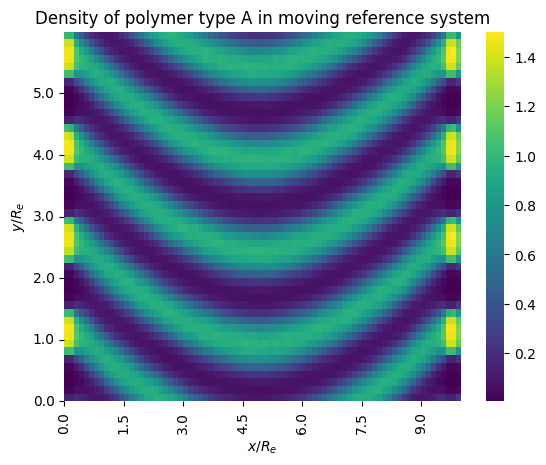

In [19]:
#get density profile average over z
phi_av=phi.mean(axis=4)[:,:,:,:]



def v_poiseuille(y,c):
    return 18*vref/rho * y**2 + c

def plot_heatmap(t,phi_av,type=0):
    #get time average in moving coordinate system
    phi_av_time=np.zeros_like(phi_av[0])
    for i in range(len(phi_av)):
        phi_av_time = phi_av_time + np.roll(phi_av[i,:,:,:],-i,-1)
    phi_av_time = phi_av_time / len(phi_av)
    print(phi_av_time.shape)
    ax=sns.heatmap(data=phi_av_time[type,:,:].T,cmap="viridis")
    stepsize=4 #stepsize for ticks
    x_ticks = ax.get_xticks()[::stepsize]-ax.get_xticks()[::stepsize].min() 
    y_ticks =ax.get_yticks()[::stepsize]-ax.get_yticks()[::stepsize].min()
    ax.set_xticks(x_ticks)
    ax.set_xticklabels(x_ticks*cell_length)
    ax.set_yticks(y_ticks)
    ax.set_yticklabels(y_ticks*cell_length)
    ax.set_xlabel("$x/R_e$")
    ax.set_ylabel("$y/R_e$")
    ax.invert_yaxis()
    ax.set_title(f"Density of polymer type A in moving reference system")
    plt.show()


plot_heatmap(0,phi_av)


#### Lamella profile extracted from the middle of the lamella using WebPlotDigitizer, use to compute curvature free energy and corresponding force.

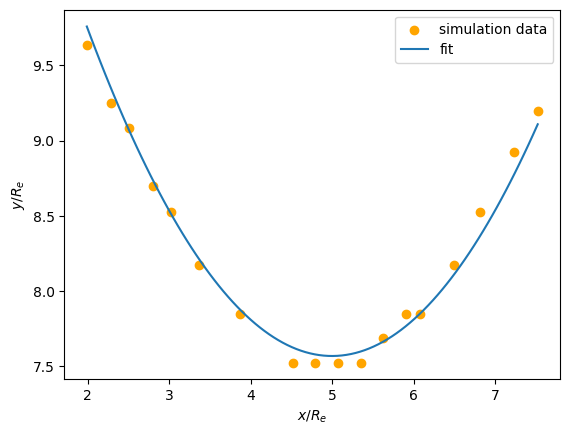

In [24]:
#offset to exclude boundary effects that disrupt parabola shape
offset=5
x_data,y_data=np.loadtxt("parabola_shape.csv",delimiter=',').T
y_ref=np.mean([y_data[0],y_data[-1]]) #reference value to calculate deformation 
x_data=x_data[offset:(-offset-1)]
y_data=y_data[offset:(-offset-1)]
mid = 5 #middle of thingy
from scipy.optimize import curve_fit

#fit parabola
def f(x,a,b):
    return a*(x-mid)**2+b
popt, pcov = curve_fit(f, x_data, y_data)

#plot
x=np.linspace(np.min(x_data),np.max(x_data),100)
plt.scatter(x_data,y_data,color='orange',label="simulation data")
plt.plot(x,f(x,popt[0],popt[1]),label="fit")
plt.xlabel("$x/R_e$")
plt.ylabel("$y/R_e$")
plt.legend()
#plt.ylim(0,6)
#plt.xlim(0,10)

In [21]:
#lamella width
lamella_ypos=np.loadtxt("lamella_spacing.csv",delimiter=',').T[1]/2
D=np.array([lamella_ypos[i]-lamella_ypos[i+1] for i in range(len(lamella_ypos)-1)])
D=D.mean()

def f_curv(x):
    """Free energy per monomer for curved lamellae.
    """
    #calculate curvature
    c=2*popt[0]/(1+4*popt[0]**2*(x-mid)**2)**1.5
    return -np.pi**2/64*D**4*c/N 
f_bend=f_curv(mid) #bending force in the middle of the lamella 
print(f"firction force: {f_fric}")
print(f"bending force in middle: {f_bend}")
print(f_fric/f_bend)

#plt.plot(x,f_curv(x))

firction force: 0.0030531451770597303
bending force in middle: -0.0007220764026908233
-4.228285491233561
